**Блокнот для проверки модели**

In [103]:
#импортируем необходимые библиотеки
import torch
import random
import pandas as pd
import numpy as np
from glob import glob
#from scripts import spym

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [104]:
from scipy import interpolate

def spline(xold, yold, xnew):
    """Spline interpolation using interpolate.CubicSpline
    xold - previous x-axis
    yold - y-data for interpolation
    xnew - new x-axis
    """
    if xold[0] > xold[-1]:
        xold = np.flipud(xold)
        yold = np.flipud(yold)
    cs = interpolate.CubicSpline(xold, yold)
    return cs(xnew)

**Импортируем датасет** \
Для ускорения загрузки и работы датасет был заранее перемешан и сформирован в две колонки: \
Iw_norm - сконкатенированные в один нормированные спектры до и после нелинейного взаимодействия в логарифмическом масштабе \
Phase - исходная спектральная фаза импульса

In [105]:
import os
import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/cKFCV0Z_4I6BnA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = str(os.getcwd()+'/')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

In [106]:
dataset = pd.read_pickle('Simple_AllData1mkm.pkl')

In [107]:
dataset

,Iw_norm,Phase
0,"[-7.173206071788765, -6.248067439688921, -6.48...","[-4.083446785719934, -3.8789060673407314, -3.6..."
1,"[-7.188025160376421, -6.25558388465318, -6.505...","[-10.381189074628114, -9.762974505219404, -9.1..."
2,"[-7.1711438479901535, -6.247148365280655, -6.4...","[-5.303288121764887, -4.9842345212907215, -4.6..."
3,"[-7.195633457322558, -6.265571028669771, -6.52...","[-14.407042676483078, -13.470667414188048, -12..."
4,"[-7.196368277772776, -6.265146463284435, -6.52...","[-10.031943193905118, -9.298209866881047, -8.5..."
...,...,...
201995,"[-7.1874847052810065, -6.258618773484933, -6.5...","[-18.97986000570287, -17.69756898614764, -16.4..."
201996,"[-7.186607918480649, -6.255838716640364, -6.50...","[-5.9707741258515314, -5.5393209106848245, -5...."
201997,"[-7.187450655750165, -6.254849864903581, -6.50...","[-17.500458053811588, -16.272484726805057, -15..."
201998,"[-7.18576805980098, -6.253371851581514, -6.505...","[-3.055795200072438, -2.9161400709290364, -2.7..."


In [108]:
new_freq = np.arange(284.5,297.5, 0.2) #частотная сетка

**Пример элементов датасета:**

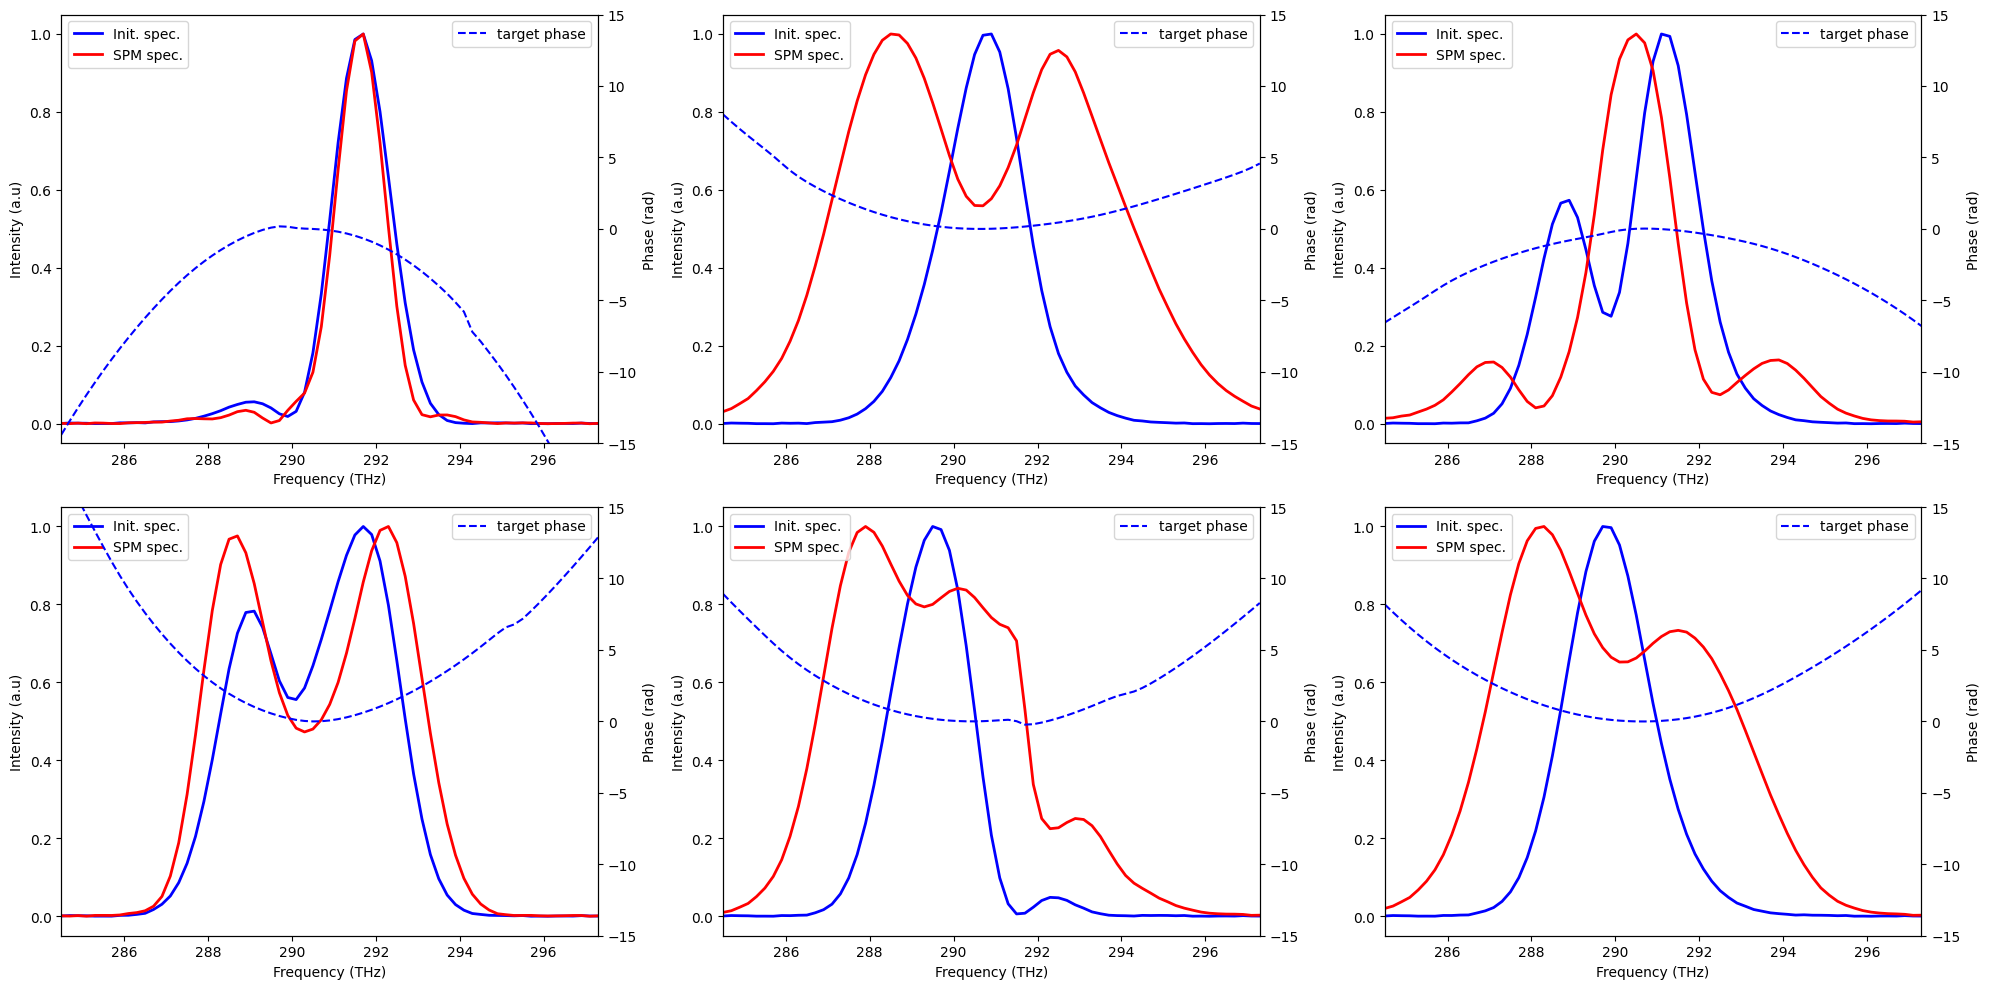

In [109]:
fig, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
indexes = [8, 231, 44244, 21223, 199999, 101010]
k=0
for i in range(2):
    for j in range(3):
        ax1[i][j].set_xlabel('Frequency (THz)')
        #print(k)
        ax1[i][j].set_ylabel('Intensity (a.u)')
        ax1[i][j].plot(new_freq, np.exp(dataset['Iw_norm'][indexes[k]][0:65]), color='blue', label = "Init. spec.",  lw = 2)
        ax1[i][j].plot(new_freq, np.exp(dataset['Iw_norm'][indexes[k]][65:]), color='red',label = "SPM spec.", lw = 2)
        vert_line1_coord = np.where(np.exp(dataset['Iw_norm'][indexes[k]][0:65])>1e-2)
        #ax1[i][j].axvline(x=new_freq[vert_line1_coord[0][0]], ls='-.', color='black')
        #ax1[i][j].axvline(x=new_freq[vert_line1_coord[0][-1]],ls='-.', color='black')
        #ax1.plot(wavelength_frog, spectr_frog, label = "FROG",  lw = 2)
        #ax1.tick_params(axis='y', labelcolor=color)
        ax1[i][j].set_xlim(new_freq[0], new_freq[-1])
        #ax1.set_ylim(1e-3, 1.05)
        ax1[i][j].legend(loc = 'upper left')
        #ax1.set_yscale('log')

        # #    ax1.set_xticks(np.arange(-300, 300, 50))
        # #    minorLocator = AutoMinorLocator()
        # #    ax1.xaxis.set_minor_locator(minorLocator)
        # #    ax1.tick_params(which='minor', length=3, width = 1)
        # #    ax1.tick_params(which='major', length=5, width = 1)

        ax2 = ax1[i][j].twinx()
        #color[i][j] = 'tab:blue'
        ax2.set_ylabel('Phase (rad)')
        ax2.plot(new_freq, dataset['Phase'][indexes[k]],'--', color='blue',  label = "target phase")#, 's', ms = 3, mew = 3, markevery= 1, linestyle = "None")
        #ax2.plot(new_freq, model_phase[k],'--', label = "model phase")
        #ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc = 'upper right')
        ax2.set_ylim(-15, 15)
        k=k+1
    #
fig.tight_layout()

plt.show()

**Разбиение датасета**

Общий размер 202 000 импульсов, из них с зафиксированным seed=42 5% отправляется на тестовую выборку \
Оставшаяся часть разбивается на тренировочную и валидационную часть в соотношение 80% на 20% \
Весь датасет нормируется на среднее и стандартное отклонение

In [110]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(torch.tensor(dataset['Iw_norm'], dtype=torch.float32), torch.tensor(dataset['Phase'], dtype=torch.float32), train_size=0.95, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

In [111]:
mean = torch.mean(x_train).item()
std = torch.std(x_train).item()

mean_phase = torch.mean(y_train).item()
std_phase = torch.std(y_train).item()

x_train_scaled = (x_train - mean)/std   
x_val_scaled = (x_val - mean)/std 
x_test_scaled = (x_test - mean)/std   

y_train_scaled = (y_train - mean_phase)/std_phase   
y_val_scaled = (y_val - mean_phase)/std_phase 
y_test_scaled = (y_test - mean_phase)/std_phase 
    
trainset = torch.utils.data.TensorDataset(x_train_scaled, y_train_scaled)
valset = torch.utils.data.TensorDataset(x_val_scaled, y_val_scaled)
testset = torch.utils.data.TensorDataset(x_test_scaled, y_test_scaled)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)#, num_workers = 5) # Здесь можно указать параметр num_workers для ускорения обучения
val_loader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False)#, num_workers = 5) #Здесь можно указать параметр num_workers для ускорения обучения
test_loader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)#, num_workers = 5) #Здесь можно указать параметр num_workers для ускорения обучения

In [112]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


**Архитектура модели**

In [113]:
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.core = nn.Sequential(
            nn.Linear(130, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 65)
        )

    def forward(self, x):
        return self.core(x)
    
SimpleModel()

SimpleModel(
  (core): Sequential(
    (0): Linear(in_features=130, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=500, out_features=500, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=500, out_features=65, bias=True)
  )
)

Я использую свою целевую метрику **Peak_Error_tensor**, функция потерь - **MSE** 

In [114]:
def Peak_Error_tensor(freq, intensity, true_phase, pred_phase):
    """
    Вычисление ошибки по значению пиковой интенсивности при восстановлении 
    временного профиля из правильной фазы и фазы модели
    Сделано через torch
    freq - частотная сетка, 
    intensity - интенсивность, 
    true_phase - правильная фаза, 
    pred_phase - фаза модели
    """
    field_0 = torch.sqrt(torch.exp(intensity))*torch.exp(true_phase*1.j)
    field_1 = torch.sqrt(torch.exp(intensity))*torch.exp(pred_phase*1.j)
    field_0_t = torch.fft.ifftshift(torch.fft.ifft(torch.fft.fftshift(field_0)))
    field_1_t = torch.fft.ifftshift(torch.fft.ifft(torch.fft.fftshift(field_1)))
    true_max = torch.max(torch.abs(field_0_t)**2)
    model_max = torch.max(torch.abs(field_1_t)**2)
    model_error = torch.abs((model_max - true_max) / true_max)
    return model_error

class XSigmoidLoss(torch.nn.Module): # Эта одна из альтернативных функций потерь, но оптимальной себя в этой задаче показала именно MSE
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)

In [115]:
class Peak_Error_Metric: #этот класс рассчитывает метрику пиковой интенсивности для батча из функции Peak_Error_tensor
    values = None

    def __init__(self, metric):
        self.reset()
        self.metric = metric

    def compute(self):
        return torch.Tensor(self.values).mean()

    def update(self, pred, target, freq, intensity):
        for i in range(pred.shape[0]):
            metric_val = self.metric(freq, intensity[i,0:65], target[i,:], pred[i,:])
            self.values.append(metric_val)      

    def reset(self):
        self.values = []
        

In [116]:
import lightning as L

from torchmetrics import MetricCollection, MeanAbsoluteError,  MeanSquaredError

class LModel(L.LightningModule):
    def __init__(self, model, freq, mean_int, std_int, mean_phase, std_phase, lr=0.0015, gamma=0.9):
        super().__init__()
        self.save_hyperparameters(logger=False)

        # for optimizer and shaduler
        self.lr = lr
        self.gamma = gamma

        # model
        self.model = model
        self.criterion = MeanSquaredError()

        # metrics
        self.train_metrics = Peak_Error_Metric(Peak_Error_tensor)
        self.val_metrics = Peak_Error_Metric(Peak_Error_tensor)
        self.test_metrics = Peak_Error_Metric(Peak_Error_tensor)
        self.freq = freq
        self.mean_int = mean_int
        self.std_int = std_int
        self.mean_phase = mean_phase
        self.std_phase = std_phase

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss" # only for self.log
            },
        }
             
    #torch 


    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(pred=out*std_phase+mean_phase, target=y*std_phase+mean_phase, freq=freq, intensity=x*std_int+mean_int)
        self.log("loss", loss, prog_bar=False)
        self.log("lossMSE/train", loss, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.val_metrics.update(pred=out*std_phase+mean_phase, target=y*std_phase+mean_phase, freq=freq, intensity=x*std_int+mean_int)
        self.log("lossMSE/val", loss, prog_bar=False)

    def on_train_epoch_end(self):
        self.log('Peak/train', self.train_metrics.compute())
        self.train_metrics.reset()
        self.log('Peak/val', self.val_metrics.compute())
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.test_metrics.update(pred=out*std_phase+mean_phase, target=y*std_phase+mean_phase, freq=freq, intensity=x*std_int+mean_int)

    def on_test_epoch_end(self):
        self.log('Peak/test', self.test_metrics.compute())
        self.test_metrics.reset()

**Код для обучения модели** 

Для его выполнения следует раскомментировать блок ниже. Для проверки результата можно загрузить уже обученную модель в блоках ниже.

In [117]:
# from lightning.pytorch.callbacks import ModelCheckpoint

# checkpoint_callback = ModelCheckpoint(
#     # dirpath='best_ckp/'
#     save_last=True,
#     every_n_epochs=1,
#     save_top_k=1,
#     save_weights_only=True,
#     monitor="Peak/val",
#     filename="model",
#     mode="min",
# )


# freq =new_freq
# mean_int, std_int, mean_phase, std_phase = torch.tensor(mean), torch.tensor(std), torch.tensor(mean_phase), torch.tensor(std_phase)

# L.seed_everything(42)

# model = SimpleModel()

# pl_model = LModel(model, freq,mean_int, std_int, mean_phase, std_phase)
# trainer = L.Trainer(
#     max_epochs=80,
#     callbacks=[checkpoint_callback],
#     #num_sanity_val_steps=0,
#     log_every_n_steps=155,
#     logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./new_dataset_x2_log_MSE/"),
# )

# trainer.fit(
#     model=pl_model,
#     train_dataloaders=train_loader,
#     val_dataloaders=val_loader
# )
# trainer.test(model=pl_model, dataloaders=test_loader, ckpt_path="best")

**Загрузим обученную модель**

In [118]:
#Загрузим модель из яндекс диска (работает в яндекс датасфере)

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/30OP3_Ed-MYOGA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = str(os.getcwd()+'/')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

ckpt_list = glob(dist_path+"/lightning_logs/version_4/checkpoints/*")
ckpt_list.sort()
ckpt_path = ckpt_list[-1]# Your code here
map_location=torch.device('cpu') 
checkpoint = torch.load(ckpt_path, map_location=map_location)

checkpoint_dict = torch.load(ckpt_path,map_location=map_location)
model = checkpoint_dict["hyper_parameters"]["model"]
print(model)

SimpleModel(
  (core): Sequential(
    (0): Linear(in_features=130, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=500, out_features=500, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=500, out_features=65, bias=True)
  )
)


**Построим несколько репрезентативных примеров работы на тестовой выборке**

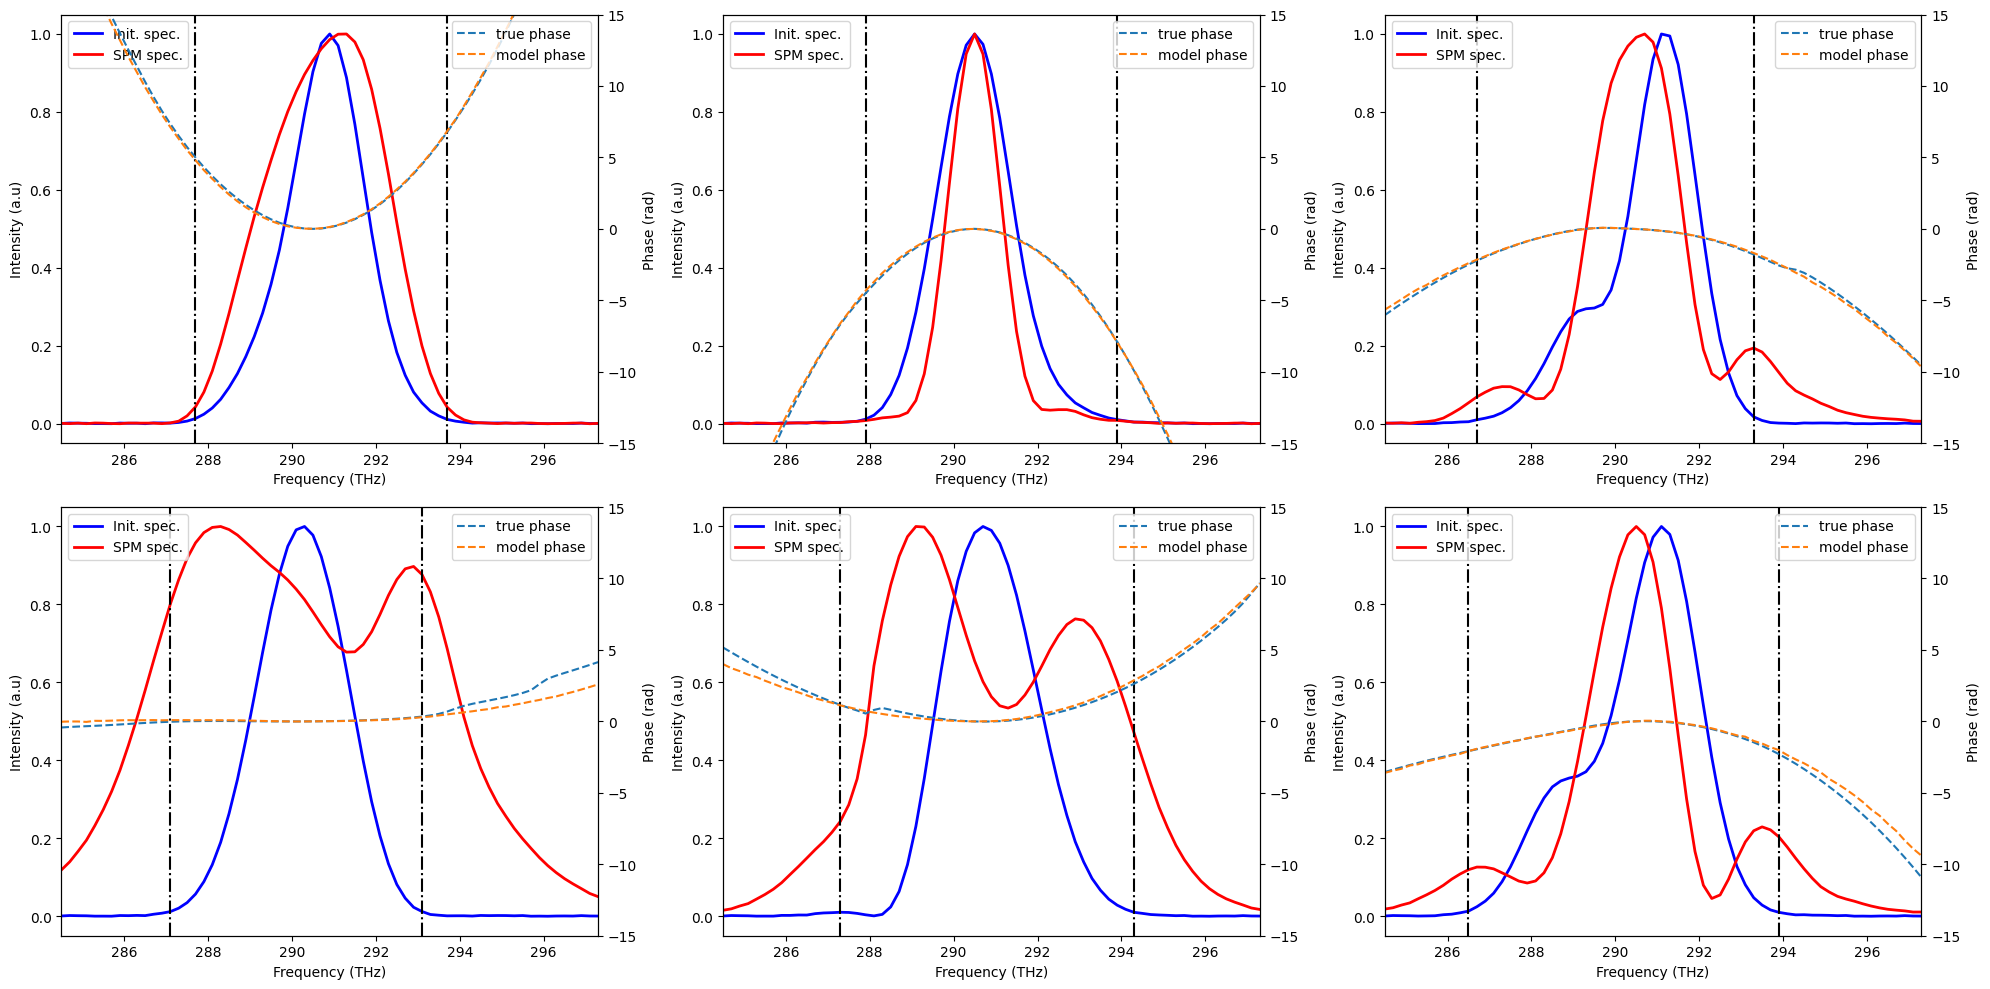

In [122]:
index_reference = [166, 9015, 3061, 5808, 9557, 7240, 1557]
model_phase = np.zeros((len(index_reference),65))
model.eval()
i=0
for idx in index_reference:
    x = x_test_scaled[index_reference[i]].unsqueeze(0)#.cuda()
    model_phase[i] = model(x).squeeze(0).cpu().detach().numpy() * std_phase + mean_phase
    i=i+1
    
fig, ax1 = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
k=0
for i in range(2):
    for j in range(3):
        ax1[i][j].set_xlabel('Frequency (THz)')
        #print(k)
        ax1[i][j].set_ylabel('Intensity (a.u)')
        ax1[i][j].plot(new_freq, np.exp(x_test[index_reference[k]][0:65]), color='blue', label = "Init. spec.",  lw = 2)
        ax1[i][j].plot(new_freq, np.exp(x_test[index_reference[k]][65:]), color='red',label = "SPM spec.", lw = 2)
        vert_line1_coord = np.where(np.exp(x_test[index_reference[k]][0:65])>1e-2)
        ax1[i][j].axvline(x=new_freq[vert_line1_coord[0][0]], ls='-.', color='black')
        ax1[i][j].axvline(x=new_freq[vert_line1_coord[0][-1]],ls='-.', color='black')
        #ax1.plot(wavelength_frog, spectr_frog, label = "FROG",  lw = 2)
        #ax1.tick_params(axis='y', labelcolor=color)
        ax1[i][j].set_xlim(new_freq[0], new_freq[-1])
        #ax1.set_ylim(1e-3, 1.05)
        ax1[i][j].legend(loc = 'upper left')
        ax2 = ax1[i][j].twinx()
        #color[i][j] = 'tab:blue'
        ax2.set_ylabel('Phase (rad)')
        ax2.plot(new_freq, y_test[index_reference[k]],'--',  label = "true phase")#, 's', ms = 3, mew = 3, markevery= 1, linestyle = "None")
        ax2.plot(new_freq, model_phase[k],'--', label = "model phase")
        #ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc = 'upper right')
        ax2.set_ylim(-15, 15)
        k=k+1
    #
fig.tight_layout()

plt.show()

Здесь вертикальные штрих-пунктирные линии обозначают область физически значимой фазы (по уровне -20dB относительно максимума спектра)

**Построим распределене ошибок пиковой интенсивности и длительности FWHM по тестовому датасету**

In [123]:
def FWHM_calc(freq_input, intensity, true_phase):
    """
    Вычисление значения длительности импульса FWHM при восстановлении 
    временного профиля
    Сделано через numpy
    
    Параметры:
        freq_input - входная частотная сетка, 
        intensity - спектральная интенсивность, 
        true_phase - спектральная фаза 
    
    Результат:
        длительность импульса FWHM в фемтосекундах
    """
    freq_input=freq_input*1e12
    freq_min = np.min(freq_input)
    freq_max = np.max(freq_input)
    
    #New frequency grid starting from zero and linear
    N = 2**15
    T = 5000*1e-15
    dt = 2*T/(N)
    time = np.arange(-T, T, dt)
    df = 1 / 2 / T
    F = 1 / 2 / dt
    freq = np.arange(-F, F, df)
    #this filter is need to proper interpolate electric field on the new denser and larger time grid
    f_filter = (freq >= freq_min) * (freq <= freq_max)
    
    #shifting Electric field and phase to the new grid        
    intensity_= spline(freq_input, intensity, freq) * f_filter
    int_filter = intensity_ >= 0
    intensity_ = intensity_*int_filter
    intensity_ = (intensity_ - np.min(intensity_))/np.max(intensity_ - np.min(intensity_))
    true_phase_ = spline(freq_input, true_phase, freq) * f_filter
    Ew_true = np.sqrt(np.abs(intensity_))*np.exp(1j*true_phase_)
    E_time_true = np.fft.ifftshift(np.fft.ifft(Ew_true))
    intensity_temp_true = np.abs(E_time_true)**2/max(np.abs(E_time_true)**2)
    tshft = time - time[np.where(intensity_temp_true==intensity_temp_true.max())]
    fwhm_true = tshft[intensity_temp_true>0.5][-1] - tshft[intensity_temp_true>0.5][0]
                                            
    return fwhm_true*1e15

In [124]:
def Peak_Error_calc(freq_input, intensity, true_phase, pred_phase):
    """
    Вычисление ошибки по значению FWHM при восстановлении 
    временного профиля из правильной фазы и фазы модели
    Сделано через numpy
    
    Параметры:
        freq_input - входная частотная сетка, 
        intensity - спектральная интенсивность, 
        true_phase - правильная спектральная фаза 
        pred_phase - модельная спектральная фаза к сравнению
    
    Результат:
        ошибка между максимальной интенсивностью от правильной фазы и модельной
    """

    freq_input=freq_input*1e12
    freq_min = np.min(freq_input)
    freq_max = np.max(freq_input)
    
    #New frequency grid starting from zero and linear
    N = 2**15
    T = 5000*1e-15
    dt = 2*T/(N)
    time = np.arange(-T, T, dt)
    df = 1 / 2 / T
    F = 1 / 2 / dt
    freq = np.arange(-F, F, df)

    #this filter is need to proper interpolate electric field on the new denser and larger time grid
    f_filter = (freq >= freq_min) * (freq <= freq_max)
   
    #shifting Electric field and phase to the new grid        
    intensity_= spline(freq_input, intensity, freq) * f_filter
    int_filter = intensity_ >= 0
    intensity_ = intensity_*int_filter
    intensity_ = (intensity_ - np.min(intensity_))/np.max(intensity_ - np.min(intensity_))
    true_phase_ = spline(freq_input, true_phase, freq) * f_filter
    pred_phase_ = spline(freq_input, pred_phase, freq) * f_filter
    Ew_true = np.sqrt(np.abs(intensity_))*np.exp(1j*true_phase_)
    Ew_pred = np.sqrt(np.abs(intensity_))*np.exp(1j*pred_phase_)
    
    #FFT and retrieving Electric field and time phase
    E_time_true = np.fft.ifftshift(np.fft.ifft(Ew_true))
    E_time_pred = np.fft.ifftshift(np.fft.ifft(Ew_pred))
    
    #retrieving temporal intensity 
    intensity_temp_true = np.abs(E_time_true)**2
    intensity_temp_pred = np.abs(E_time_pred)**2
    peak_error = np.abs(intensity_temp_true.max() - intensity_temp_pred.max()) / intensity_temp_true.max() 
                                         
    return peak_error

Для экономии времени я закомментировал код расчёта распределения ошибок, но при желании его можно выполнить (обычно занимает несколько минут).

In [125]:
# results_test = []
# col_names = ['true_fwhm','model_fwhm','fwhm_error', 'model_error']
# results_test= pd.DataFrame(columns=col_names)
# model.eval()

# for idx in range(len(x_test_scaled)):
#     a = x_test_scaled[idx].unsqueeze(0).cpu()
#     model_phase = model(a).squeeze(0).cpu().detach().numpy() *std_phase.numpy()+mean_phase.numpy()
#     intensity = np.exp(x_test[idx][0:65]).detach().numpy()
#     #сделаем фильтр для работы только в физически значимой области спектра -20dB от максимума интенсивности
#     db20_filter = []
#     for i in range(len(intensity)): 
#         db20_filter.append(1 if intensity[i]>1e-2 else 0)
#     db20_filter=np.array(db20_filter)
#     true_fwhm = FWHM_calc(new_freq, intensity, y_test[idx].detach().numpy()*db20_filter)
#     model_fwhm = FWHM_calc(new_freq, intensity, model_phase*db20_filter)
#     fwhm_error = np.abs((true_fwhm-model_fwhm)/true_fwhm)
#     model_error = Peak_Error_calc(new_freq, intensity, y_test[idx].detach().numpy()*db20_filter, model_phase*db20_filter)
#     d = [true_fwhm, model_fwhm, fwhm_error, model_error]
#     results_test.loc[idx] = d

In [126]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/9RTkk7e6-t9buA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = str(os.getcwd()+'/')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

results_test = pd.read_pickle('Results_to_plot.pkl')

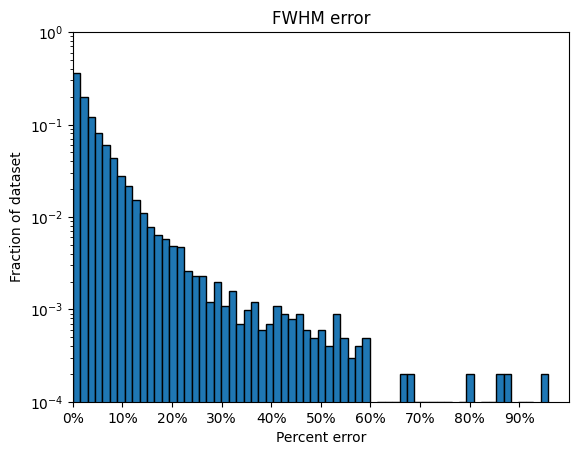

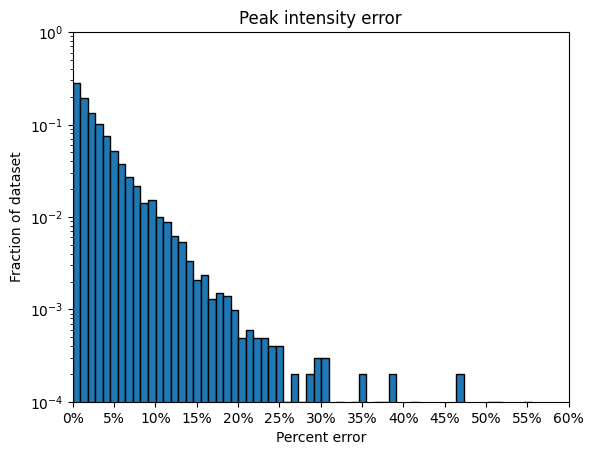

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.hist(results_test['fwhm_error'],bins=260,density=False, weights=np.ones(len(results_test)) / len(results_test), edgecolor='black')
#apply percentage format to y-axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_xlim(0,1)
plt.gca().set_xlabel('Percent error')
plt.gca().set_xticks(np.arange(0,1,0.1))
#plt.gca().set_yticks(np.arange(0,1,0.05))
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-4,1)
plt.gca().set_ylabel('Fraction of dataset')
plt.gca().set_title('FWHM error')
plt.show()


plt.hist(results_test['model_error'],bins=260,density=False, weights=np.ones(len(results_test)) / len(results_test), edgecolor='black')
#apply percentage format to y-axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_xlim(0,1)
plt.gca().set_xlabel('Percent error')
plt.gca().set_ylabel('Fraction of dataset')
plt.gca().set_xticks(np.arange(0,0.8,0.05))
plt.gca().set_xlim(0,0.6)
#plt.gca().set_yticks(np.arange(0,0.9,0.05))
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-4,1)
plt.gca().set_title('Peak intensity error')
plt.show()

In [128]:
print('Ошибка пиковой интенсивности: ', round(results_test['model_error'].mean()*100,1),'% среднее, ', round(results_test['model_error'].std()*100,1),'% станд. отклон.')
print('Ошибка длительности FWHM: ', round(results_test['fwhm_error'].mean()*100,1),'% среднее, ', round(results_test['fwhm_error'].std()*100,1),'% станд. отклон.')

Ошибка пиковой интенсивности:  3.2 % среднее,  4.9 % станд. отклон.
Ошибка длительности FWHM:  4.9 % среднее,  9.4 % станд. отклон.


**Проверим на экспериментальных данных**

In [129]:
#Загрузим данные из эксперимента:

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/f8Kx7OoPn9x8EA'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = str(os.getcwd()+'/')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)


In [130]:
def Plot_temporal_comparison(freq_input, intensity, model_phase, freq_frog, intensity_frog, frog_phase):
    """
    Функция построения на одном графике временных огибающих пары импульсов (второй предполагается из методики FROG)
        
    Параметры:
        freq_input - входная частотная сетка первого импульса, 
        intensity - спектральная интенсивность первого импульса, 
        true_phase - спектральная фаза первого импульса, 
        freq_frog - входная частотная сетка второго импульса, 
        intensity_frog - спектральная интенсивность второго импульса, 
        frog_phase - спектральная фаза второго импульса, 
    
    Результат:
        построение графиков временных интенсивностей, вывод длительности первого и второго(FROG) импульса c
        процентной ошибкой длительностей
    """
    freq_input=freq_input*1e12
    freq_min = np.min(freq_input)
    freq_max = np.max(freq_input)
    
    freq_input_frog=freq_frog*1e12
    freq_frog_min = np.min(freq_input_frog)
    freq_frog_max = np.max(freq_input_frog)
    
    #New frequency grid starting from zero and linear
    N = 2**15
    T = 5000*1e-15
    dt = 2*T/(N)
    time = np.arange(-T, T, dt)
    df = 1 / 2 / T
    F = 1 / 2 / dt
    freq = np.arange(-F, F, df)
    f_filter = (freq >= freq_min) * (freq <= freq_max)
    f_filter_frog = (freq >= freq_frog_min) * (freq <= freq_frog_max)
    
    #shifting Electric field and phase to the new grid        
    intensity_= spline(freq_input, intensity, freq) * f_filter
    int_filter = intensity_ >= 0
    intensity_ = intensity_*int_filter
    intensity_ = (intensity_ - np.min(intensity_))/np.max(intensity_ - np.min(intensity_))

    intensity_frog_= spline(freq_input_frog, intensity_frog, freq) * f_filter_frog
    int_filter_frog = intensity_frog_ >= 0
    intensity_frog_ = intensity_frog_*int_filter_frog
    intensity_frog_ = (intensity_frog_ - np.min(intensity_frog_))/np.max(intensity_frog_ - np.min(intensity_frog_))
    
    model_phase_ = spline(freq_input, model_phase, freq) * f_filter
    frog_phase_ = spline(freq_input_frog, frog_phase, freq) * f_filter_frog
    
    Ew_model = np.sqrt(np.abs(intensity_))*np.exp(1j*model_phase_)
    Ew_freq = np.sqrt(np.abs(intensity_frog_))*np.exp(1j*frog_phase_)
    
    #FFT and retrieving Electric field and time phase
    E_time_model = np.fft.ifftshift(np.fft.ifft(Ew_model))
    E_time_frog = np.fft.ifftshift(np.fft.ifft(Ew_freq))
    
    #retrieving temporal intensity 
    intensity_temp_model = np.abs(E_time_model)**2/max(np.abs(E_time_model)**2)
    intensity_temp_frog = np.abs(E_time_frog)**2/max(np.abs(E_time_frog)**2)

    tshft = time - time[np.where(intensity_temp_model==intensity_temp_model.max())]
    tshft2 = time - time[np.where(intensity_temp_frog==intensity_temp_frog.max())]
    
    fig, ax1 = plt.subplots()
    ax1.plot(tshft*1e15, intensity_temp_model, label = 'Model')
    ax1.plot(tshft2*1e15, intensity_temp_frog, 'g', label = 'FROG')
    fwhm_model = tshft[intensity_temp_model>0.5][-1] - tshft[intensity_temp_model>0.5][0]
    print('fwhm_model = ', round(fwhm_model*1e15), 'fs')
    fwhm_frog = tshft2[intensity_temp_frog>0.5][-1] - tshft2[intensity_temp_frog>0.5][0]
    print('fwhm_frog = ', round(fwhm_frog*1e15), 'fs')
    print('fwhm_error = ', round(100*(fwhm_model-fwhm_frog)/fwhm_frog,1), '%')

    ax1.set_xlim((-500,500))
    ax1.set_xlabel('Time (fs)')
    ax1.set_ylabel('Intensity (a.u.)')
    ax1.legend()
    return tshft*1e15, intensity_temp_model

fwhm_model =  217 fs
fwhm_frog =  213 fs
fwhm_error =  1.9 %


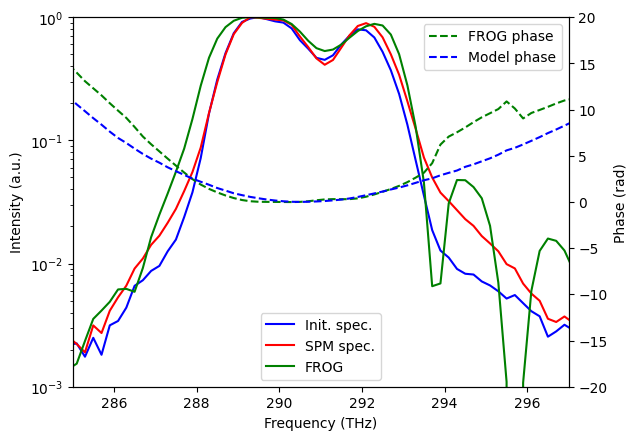

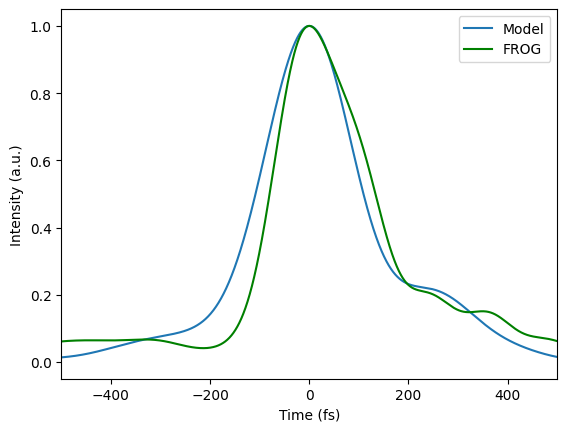

In [132]:
files = [
    "Experiment Files/90cmOrig25Deg.txt",
    "Experiment Files/90cmSFM25Deg.txt",
    ]

wavelength = np.zeros(0)
spectras = []
for count, file in enumerate(files):
    spectrum = np.zeros(0)
    with open(file) as f:
        lines = f.readlines()

    for i in range(17, len(lines)-2):
        a = (lines[i].replace(',', '.')).strip()
        b = a.split()
        #print(b)
        if count == 0:
            wavelength = np.append(wavelength, np.float64(b[-2]))
        spectrum = np.append(spectrum, np.float64(b[-1]))
    spectrum[spectrum < 0] = 0
    
    spectrum = (spectrum - np.min(spectrum)) / (np.max(spectrum))
    spectras.append(spectrum)

wavelength_frog = []
spectr_frog, phase = [], []
with open("Experiment Files/Speck213fs.dat") as f:
    lines = f.readlines()
for i in range(0, len(lines)):
        a = (lines[i].replace(',', '.')).strip()
        b = a.split()
        wavelength_frog = np.append(wavelength_frog, np.float64(b[0]))
        spectr_frog = np.append(spectr_frog, np.float64(b[1]))
        phase = np.append(phase, -np.float64(b[2]))

freq_frog = 299792.458/wavelength_frog
phase = phase - phase[len(phase)//2]
intensity_calc = spline(wavelength, spectras[0], wavelength_frog)
#intensity_calc[intensity_calc<0.01]=0
intensity_calc[wavelength_frog<900]=0
intensity_calc[wavelength_frog>1070]=0
intensity_calc = intensity_calc*wavelength_frog**2
intensity_calc = intensity_calc/np.max(intensity_calc)

intensity_calc_1 = spline(wavelength, spectras[1], wavelength_frog)
#intensity_calc_1[intensity_calc_1<0.01]=0
intensity_calc_1[wavelength_frog<900]=0
intensity_calc_1[wavelength_frog>1070]=0
intensity_calc_1 = intensity_calc_1*wavelength_frog**2
intensity_calc_1 = intensity_calc_1/np.max(intensity_calc_1)

# fig, ax1 = plt.subplots()

# ax1.plot(freq_frog, intensity_calc, label = 'Exp.')
# ax1.plot(freq_frog, intensity_calc_1, label = 'SFM Exp.')
# ax1.plot(freq_frog, spectr_frog,'g', label = 'FROG')
# ax1.set_xlim((280,300))
# ax1.legend(loc='lower left')
# ax2 = ax1.twinx()
# #ax1.set_xlim((1e-4,1e0))
# ax2.plot(freq_frog, phase,'g--', label = 'FROG phase')
# ax2.legend(loc='upper right')
# ax2.set_ylim((-20,20))
# ax1.set_xlabel('Frequency (THz)')
# ax1.set_ylabel('Intensity (a.u.)')
# ax2.set_ylabel('Phase (rad)')

freq = new_freq
intensity_exp_orig = spline(freq_frog, intensity_calc, freq)
intensity_exp_SFM = spline(freq_frog, intensity_calc_1, freq)
intensity_frog = spline(freq_frog, spectr_frog, freq)
phase_exp = spline(freq_frog, phase, freq)

intensity_exp_orig = intensity_exp_orig / intensity_exp_orig.max()
intensity_exp_SFM = intensity_exp_SFM/intensity_exp_SFM.max()

model.eval()
intensity_exp = (np.log(np.abs(np.concatenate((intensity_exp_orig,intensity_exp_SFM))))-mean)/std
#torch.tensor(dataset_shuffled_norm['Iw_norm'], dtype=torch.float32),
a = torch.tensor(intensity_exp, dtype=torch.float32).unsqueeze(0).cpu()
model_phase_t = model(a).squeeze(0)
model_phase = model_phase_t.cpu().detach().numpy() *std_phase+mean_phase
ax2.plot(freq, model_phase,'b--', label = 'Model phase')

fig, ax1 = plt.subplots()

ax1.plot(freq, intensity_exp_orig,color='blue', label = 'Init. spec.')
ax1.plot(freq, intensity_exp_SFM, color='red', label = 'SPM spec.')
ax1.plot(freq, intensity_frog,'g', label = 'FROG')
ax1.set_yscale("log")
ax1.set_ylim((1e-3,1e0))
ax1.set_xlim((285,297))
ax2 = ax1.twinx()
ax2.set_ylim((-20,20))
ax1.set_xlabel('Frequency (THz)')
ax1.set_ylabel('Intensity (a.u.)')
ax2.set_ylabel('Phase (rad)')
ax1.legend(loc='lower center')

ax2.plot(freq, phase_exp, 'g--', label = 'FROG phase')
ax2.plot(freq, model_phase,'b--', label = 'Model phase')
ax2.legend(loc='upper right')

intensity_spline = spline(freq, intensity_exp_orig, new_freq)
intensity_spline[intensity_spline<0.02]=0 #чистка от шумов)

tshft0, intensity_temp_model = Plot_temporal_comparison(new_freq, intensity_spline, model_phase, freq, intensity_frog, phase_exp)